In [1]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 45.0 MB/s eta 0:00:00


In [11]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# base_dir = "/content/drive/MyDrive/Colab Notebooks/raw_data/"
base_dir = "/content/drive/MyDrive/Colab Notebooks/TestDataJC/Raw_data"

In [12]:
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [13]:
def load_data(directory, detector, num_landmarks=478):
    columns = [f'{coord}{i}' for i in range(1, num_landmarks + 1) for coord in ('x', 'y', 'z')]
    columns.append('y')  # Add the new column for the target feature
    data_df = pd.DataFrame(columns=columns)
    incorrect = []

    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                cv_mat = cv.imread(file_path)
                if cv_mat is None:
                    print(f"Failed to load image {file_path}")
                    continue
                image = mp.Image.create_from_file(file_path)
                detection_result = detector.detect(image)
                all_landmarks = []
                for landmark_coords in detection_result.face_landmarks:
                    for landmark in landmark_coords:
                        all_landmarks.extend([landmark.x, landmark.y, landmark.z])
                if len(all_landmarks) != num_landmarks * 3:
                    incorrect.append(file_path)
                    continue
                # y_value = 1 if 'Stroke' in folder_path else 0
                y_value = 1 if folder == 'Stroke' else 0
                all_landmarks.append(y_value)
                data_df.loc[len(data_df)] = all_landmarks
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue
    return data_df, incorrect


In [14]:
# Function to perform model fitting and evaluation
def fit_evaluate_model(X_train_pca, y_train, X_test_pca, y_test):
    # Initialize XGBoost classifier
    xgb_clf = xgb.XGBClassifier()
    # Train the model
    xgb_clf.fit(X_train_pca, y_train)
    # Make predictions
    y_pred = xgb_clf.predict(X_test_pca)
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [15]:
# Load and process data
base_dir = "/content/drive/MyDrive/Colab Notebooks/TestDataJC/Raw_data"
detector = vision.FaceLandmarker.create_from_options(options)  # Assuming options are already defined

train_dir = os.path.join(base_dir, 'processed_train')
test_dir = os.path.join(base_dir, 'processed_test')

train_df, incorrect_train = load_data(train_dir, detector)
test_df, incorrect_test = load_data(test_dir, detector)

X_train, y_train = train_df.drop('y', axis=1), train_df['y']
X_test, y_test = test_df.drop('y', axis=1), test_df['y']


In [16]:
# Assuming X_test and y_test are your testing features and labels
indices = np.arange(len(X_test))  # Use len(X_test) to get the number of rows
np.random.shuffle(indices)

# Use .iloc for positional indexing
X_test_shuffled = X_test.iloc[indices]
y_test_shuffled = y_test.iloc[indices]

In [17]:
# Apply PCA, in our case, we can use n_components with another value 16 or 15
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

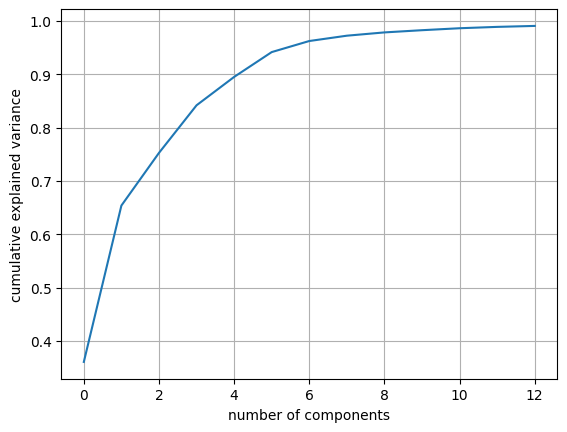

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

In [19]:
# Initialize Support Vector Classifier
svc_clf = SVC(probability=True)

In [20]:
# Create a pipeline that applies PCA and then fits an SVC
pipeline = Pipeline([('pca', pca), ('svc', svc_clf)])

In [21]:
# Define the grid search parameter grid for SVC
param_grid_svc = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}

In [22]:
# Initialize GridSearchCV for SVC
grid_search_svc = GridSearchCV(estimator=pipeline, param_grid=param_grid_svc, scoring='recall', n_jobs=-1, cv=5)

# Fit the model using GridSearchCV
grid_search_svc.fit(X_train, y_train)  # No need to use X_train_pca because PCA is part of the pipeline

# Optimal model evaluation
best_svc_clf = grid_search_svc.best_estimator_

# Make predictions using the best model
y_pred_svc = best_svc_clf.predict(X_test)  # No need to use X_test_pca for the same reason as above

# Evaluate the model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
report_svc = classification_report(y_test, y_pred_svc)

print("SVC Accuracy:", accuracy_svc)
print("\nSVC Classification Report:\n", report_svc)

# Print the best parameters
print("Best parameters found for SVC: ", grid_search_svc.best_params_)

SVC Accuracy: 0.665

SVC Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.26      0.41        88
         1.0       0.63      0.98      0.77       112

    accuracy                           0.67       200
   macro avg       0.77      0.62      0.59       200
weighted avg       0.76      0.67      0.61       200

Best parameters found for SVC:  {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
